## Welcome to the first-ever (and hopefully last-ever) remote ADA final exam (Fall 2020)

In this exam, you will analyze data from Wikipedia and from the [Wikispeedia](https://dlab.epfl.ch/wikispeedia/play/) game, which you have already encountered in lecture 12 on [“Handling networks”](https://docs.google.com/presentation/d/1h6cIINJ9cNZ-Rtb7SskXrl9Xet5zPUoX2oJlNM0loHQ/edit#slide=id.g464f30ace1_0_92). The rules of the Wikispeedia game are simple:
1. Players are given two Wikipedia articles: a *source* and a *target*.
2. Starting from the source article, the goal is to reach the target, exclusively by following links in the articles encountered along the path.

### The data

The Wikispeedia data comprises ~76K games by human players, thereby capturing human navigation behavior on a very small subset of English Wikipedia comprising ~4.5K articles with a total of ~120K links between them.

The dataset is available in the `data` directory pushed to the same GitHub repo as the exam. Inside the data directory, you will find four files:

####  1. `article_df_task-A.tsv.gz`: A tab-separated file with the following information about Wikipedia articles
- *name*: The name of the Wikipedia article
- *topic*: The top-level topic label for the article (each article is assigned exactly one topic label)
- *content*: The cleaned text of the article (having removed punctuations, stopwords, numbers, and letter casing). It is stored as a space-separated string.

#### 2. `links_task-B.tsv.gz`: A tab-separated file containing Wikipedia links
- *linkSource*: The name of the source Wikipedia article from which the link originates
- *linkTarget*: The name of the target Wikipedia article to which the link points

#### 3.  `paths_df_task-B.tsv.gz`: A tab-separated file with the following information about the played games
- *hashed_ip_address*: Anonymized IP address of the player
- *source*: The name of the Wikipedia article from where the game started
- *target*: The name of the target article that the player was supposed to reach 
- *finished*: Whether the game was successfully finished (whether the player reached the target article)
- *human_path_length*: The number of clicks made by the player, before they either reached the target (in *finished* games) or gave up (in *unfinished* games)
- *shortest_path_length*: The minimum number of clicks required to reach the target article from the source article. Disconnected source-target article pairs have a shortest_path_length of *-1*.
- *duration_in_sec*: The duration of the game in seconds

#### 4.  `paths_df_task-C.tsv.gz`: In continuation to the task-B paths dataframe, this tab-separated file has the following additional information
- *in_degree_target*: In-degree of the target article, that is the number of incoming links that lead to the target article

*Note: In all the aforementioned files, the first line contains the header information. Additionally, article names are URL-encoded. For example, 'Antonín_Dvořák' is stored as 'Anton%C3%ADn_Dvo%C5%99%C3%A1k'. If needed, you can decode the article names using this code: `from urllib.parse import unquote; unquote('article-name')`.*

In [2]:
''' Some minimalistic imports '''
import pandas as pd
import random
import gzip
import operator
import time
from urllib.parse import unquote

import math
import numpy as np
import scipy.stats as stats
import sklearn

import networkx as nx

from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# More imports
import sklearn.feature_extraction
import sklearn.model_selection 
import sklearn.linear_model
import sklearn.metrics
import sklearn.dummy
from operator import itemgetter
from collections import Counter

# Task A. Can we predict article topic using textual content? (30 points)

*Note-1: For the entire Task A, we will use logistic regression for its scalability and simplicity. Specifically, we will use [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) available in `sklearn` with 'log' loss and '5' epochs for training a logistic regression classifier.*

*Note-2: In all the cases where random number generation is required (train-test split, fitting the model, etc.), make sure to use 42 as the random seed.*

### A1. Load the text data and analyze the topic distribution (2 points)
1. Load `data/article_df_task-A.tsv.gz` as a pandas dataframe.   
   *Note: we have already cleaned the text for you!*
2. Print the total number of unique topics. Additionally, using a plot of appropriate type, analyze the article topic distribution.   
   **/Discuss:/** What do you observe? Are different topics equally likely? If not, is there a large disparity between certain highly popular and very rare topics?

In [5]:
'''your code here''';

dataA = pd.read_csv('data/article_df_task-A.tsv.gz', sep='\t')

In [12]:
dataA.name = dataA.name.apply(unquote)

In [17]:
# Number of unique topics
len(dataA.topic.unique())

14

In [27]:
topic_freq = dataA.groupby('topic').topic.count()
topic_freq

topic
Art                          33
Business_Studies             76
Citizenship                 196
Design_and_Technology       210
Everyday_life               310
Geography                  1058
History                     434
IT                           75
Language_and_literature     175
Mathematics                  43
Music                        96
People                      673
Religion                    114
Science                    1105
Name: topic, dtype: int64

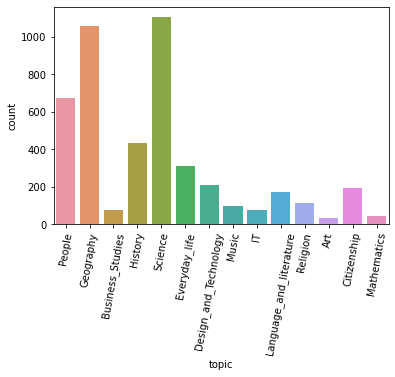

In [102]:
sns.countplot(x='topic', data=dataA)
plt.xticks(rotation=80);

Topics are not equally likely and the disparity is high: 1105 for the most popular Science vs 33 for Art.

### A2. Topic classification (multi-class): Articles from 5 most frequent topics (8 points)

#### A2.1 Prepping the data for ML (3 points)
1. Restrict the data to articles corresponding to the top-5 topics based on topic frequency.
2. Construct a TF-IDF representation of textual content.
3. Classes are defined by the topic labels, which are given as *strings*. However, for training classifiers via `sklearn` the class labels need to be encoded as ordinals. Perform this encoding and add a new column of ordinal class labels in the current dataframe.
4. Create two numpy arrays: X (TF-IDF representation of each article) and y (class-label of each article).

#### A2.2 Train and evaluate a multi-class classifier (5 points)
1. Perform a train-test split with 70% as the training portion and the remainder as the testing portion. Use `random_state=42` for fixing the seed to 42.
2. Train a logistic regression classifier with L2 regularization using the `SGDClassifier()` method of `sklearn`. Use `SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)` to initialize the classifier object. Do not modify the settings for any other parameter, let them be set to their default values.   
   **Important heads-up**: *Depending on the configuration of your computer, training the model could take up to 1 minute of compute time.*
3. Report the classifier performance on the test data using accuracy as the metric.
4. **/Discuss:/** Are you satisfied with the model performance? Qualitatively discuss the performance of the model by comparing it to a random baseline and justify your response.

**Important note:** *Based on the discussion in the class, logistic regression is a binary classification technique. A simple heuristic to perform multi-class classification using a binary classifier is to use the [one-vs.-rest (OVR)](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest) strategy. In this strategy, a binary classifier is trained for each class with the capability to differentiate it from all the other classes, and thus, $k$ binary classifiers are trained for a $k$-class classification. Internally, `SGDClassifier()` uses the [OVR](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) strategy of `sklearn` whenever it sees the number of unique values in the **y** vector to be greater than 2. Thus, you can simply use it as a black-box! The only important point for this part is to make sure that the **y** vector of class-labels should have **5** unique values, one corresponding to each class-label.*

In [35]:
'''your answer/code here''';
popular_topics = topic_freq.sort_values(ascending=False)[:5]
popular_topics

topic
Science          1105
Geography        1058
People            673
History           434
Everyday_life     310
Name: topic, dtype: int64

In [65]:
dataA_pop = dataA[dataA.topic.isin(popular_topics.index)]
dataA_pop

,name,topic,content
0,Áedán_mac_Gabráin,People,copyright aedan mac gabrain schools wikipedia ...
1,Åland,Geography,copyright aland schools wikipedia selection re...
2,Édouard_Manet,People,copyright edouard manet schools wikipedia sele...
3,Éire,Geography,copyright eire schools wikipedia selection rel...
4,Óengus_I_of_the_Picts,People,copyright oengus picts schools wikipedia selec...
...,...,...,...
4593,Zionism,People,copyright zionism schools wikipedia selection ...
4594,Zirconium,Science,copyright zirconium schools wikipedia selectio...
4595,Zoroaster,People,copyright zoroaster schools wikipedia selectio...
4596,Zuid-Gelders,Geography,copyright zuid gelders schools wikipedia selec...


In [284]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()
X = vectorizer.fit_transform(dataA_pop.content.values)

In [68]:
dataA_pop.topic = dataA_pop.topic.astype('category', copy=False)

C:\Users\franc\ProgramsAltri\anaconda3\envs\adaexam\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [69]:
# Label embedding
dataA_pop['label'] = dataA_pop.topic.cat.codes

C:\Users\franc\AppData\Local\Temp/ipykernel_15580/3195415998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataA_pop['label'] = dataA_pop.topic.cat.codes


In [71]:
y = dataA_pop.label

#### A2.2

In [214]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [215]:
model = sklearn.linear_model.SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)

In [216]:
model.fit(X_train, y_train)

SGDClassifier(loss='log', max_iter=5, random_state=42, tol=None)

In [217]:
y_pred = model.predict(X_test)

In [218]:
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
accuracy

0.8808193668528864

In [219]:
baseline = sklearn.dummy.DummyClassifier(strategy='stratified')

In [220]:
y_base = baseline.fit(X_train, y_train).predict(X_test)

In [221]:
accuracy_base = sklearn.metrics.accuracy_score(y_test, y_base)
accuracy_base

0.24767225325884543

The classifier is already performing very good, with an average accuracy of 88%, significantly better than the baseline accuracy of 23%. However, only looking at accuracy does not tell us if the performance is also good on the single topics.

### A3. Topic classification (binary): Articles from the most and least frequent topics (12 points)

#### A3.1 Train and evaluate a binary classifier (2 points)
1. Restrict the data to articles belonging to the most frequent or to the least frequent topic.
2. Create two numpy arrays: X (TF-IDF representation of each article) and y (class-label of each article).
3. Perform a train-test split with 70% as the training portion and the remainder as the testing portion. Use `random_state=42` for fixing the seed to 42.
4. Train a logistic regression classifier with L2 regularization using the `SGDClassifier()` method of `sklearn`. Use `SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)` to initialize the classifier object. Do not modify the settings for any other parameter, let them be set to their default values.
5. Report the classifier performance on the test data using accuracy as the metric.

In [4]:
'''your answer/code here''';

1.

In [114]:
binary_topics = topic_freq.sort_values(ascending=False)[[0, -1]]
binary_topics

topic
Science    1105
Art          33
Name: topic, dtype: int64

In [135]:
dataA_binary = dataA[dataA.topic.isin(binary_topics.index)]

2.

In [138]:
X_bin = sklearn.feature_extraction.text.TfidfVectorizer().fit_transform(dataA_binary.content.values)
dataA_binary.topic = dataA_binary.topic.astype('category', copy=False)
dataA_binary['label'] = dataA_binary.topic.cat.codes
y_bin = dataA_binary.label

C:\Users\franc\ProgramsAltri\anaconda3\envs\adaexam\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\franc\AppData\Local\Temp/ipykernel_15580/1724360639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataA_binary['label'] = dataA_binary.topic.cat.codes


3.

In [142]:
X_bin_train, X_bin_test, y_bin_train, y_bin_test = sklearn.model_selection.train_test_split(X_bin, y_bin, test_size=0.3, random_state=42)

4.

In [148]:
model = sklearn.linear_model.SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)
model.fit(X_bin_train, y_bin_train)
y_bin_pred = model.predict(X_bin_test)

5.

In [149]:
accuracy = sklearn.metrics.accuracy_score(y_bin_test, y_bin_pred)
accuracy

0.9678362573099415

#### A3.2 Assessing the evaluation metric (5 points)
1. **/Discuss:/** What is your take on the accuracy obtained in A3.1? Do you think accuracy is the correct evaluation metric for this task? If yes, justify! If not, why not, and what else can be used?
2. If you included additional evaluation metrics in A3.2.1, then perform an empirical analysis of the performance using these metrics.   
   **/Discuss:/** Additionally, discuss what you observe. Is it harder to predict the topic labels of certain articles? Why, or why not? Please elaborate!

1.

Accuracy is not a meaningful metric, as the classes are hugely unbalanced in this problem. Hence, one would obtain a very good accuracy just by predicting the label of the most dominant class, as this metric does not tell anything on the performance on each class. In the inbalanced case, we could use the F1-score, for both the positive and the negative class.

2.

In [153]:
# With respect to label 1, i.e. topic Science
sklearn.metrics.f1_score(y_bin_test, y_bin_pred, pos_label=1)

0.9835575485799701

In [154]:
# With respect to label 0, i.e. topic Art
sklearn.metrics.f1_score(y_bin_test, y_bin_pred, pos_label=0)

0.26666666666666666

We see now that the performances on articles belonging to the Science topic is much better then than on Art articles, thus in the end the classifier is not performing very good in the end, if we take into account the performances separately. In general, it is harder for the classifier to adapt to Art articles since the original dataset is very inbalanced, hence very few training examples belong to Art articles and during training the classifier learns to predict Science much more often.

#### A3.3 Class proportions (5 points)
1. **/Discuss:/** Does the disparity in class proportions hurt the model? If yes, how can you fix it? If not, why not? Justify your response with clear and crisp reasons!    
   *Hint: The learning objective of a classifier can be modified by altering the importance of each class in the computation of the loss function.*
2. If your answer to the aforementioned question is a "yes", please do the following. If not, move to **Task A4**.
    * Implement the fix you proposed in A3.3.1, and repeat the classification task performed in Step A3.1 using the fixed model.
    * Vary the regularization parameter `alpha` in the range [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], and using accuracy as the metric find and report its optimal value using 5-fold cross validation on the training set.   
       **Important heads-up**: *Depending on the configuration of your computer, grid search for the optimal value of `alpha` could take up to 1 minute of compute time.*
    * Lastly, using the optimal `alpha` identified in the previous step, redo the evaluations proposed in A3.2.   
       **/Discuss:/** Do you observe any differences from the results obtained in A3.2? Why, or why not? Please elaborate!

In [6]:
'''your answer/code here''';

1.

The disparity hurts the model in the sense that the model will not be able to meaningfully recognize Art articles, hence it will only work well on Science article, which means that overall as a binary separation it will perform bad. This issue can be fixed or at least mitigated if we subsample the article population by oversampling the underrepresented class or downsampling the overrepresented class. This in practice can be also implemented by giving a difference importance, in terms of loss, to members of the two classes.

2.

In [172]:
weights = 1 - dataA_binary.groupby('label').label.count() / len(dataA_binary)
weights = weights.to_dict()
weights

{0: 0.9710017574692443, 1: 0.02899824253075567}

In [173]:
model = sklearn.linear_model.SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42, class_weight=weights)

In [174]:
model.fit(X_bin_train, y_bin_train)
y_bin_pred = model.predict(X_bin_test)

In [175]:
accuracy = sklearn.metrics.accuracy_score(y_bin_test, y_bin_pred)
accuracy

0.9941520467836257

3.

In [204]:
accs = {}
for alpha in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    model_alpha = sklearn.linear_model.SGDClassifier(loss='log', max_iter=5, tol=None, alpha=alpha, random_state=42, class_weight=weights)
    accuracies = sklearn.model_selection.cross_val_score(model, X_bin_train, y_bin_train, scoring='accuracy', cv=5)
    accs[alpha] = accuracies.mean()

In [196]:
sorted(accs.items(), key=itemgetter(1), reverse=True)

[(1e-06, 0.9987421383647799),
 (1e-05, 0.9987421383647799),
 (0.0001, 0.9987421383647799),
 (0.001, 0.9962264150943396),
 (0.1, 0.9912106918238994),
 (0.01, 0.9874371069182389)]

In [205]:
opt_alpha = 1e-6
model_opt = sklearn.linear_model.SGDClassifier(loss='log', max_iter=5, tol=None, alpha=opt_alpha, random_state=42, class_weight=weights)
model_opt.fit(X_bin_train, y_bin_train)
y_bin_pred = model.predict(X_bin_test)

In [203]:
accuracy = sklearn.metrics.accuracy_score(y_bin_test, y_bin_pred)
accuracy

0.9941520467836257

In [200]:
# With respect to label 1, i.e. topic Science
sklearn.metrics.f1_score(y_bin_test, y_bin_pred, pos_label=1)

0.996969696969697

In [201]:
# With respect to label 0, i.e. topic Art
sklearn.metrics.f1_score(y_bin_test, y_bin_pred, pos_label=0)

0.9166666666666666

Indeed, the performances are now much better, both overall and on both classes. In particular, Art articles have now a very good F1-score of above 0.9

### A4. Revisiting Multi-class classifier of A2.2 (4 points)

1. Print and analyze the confusion matrix for the multi-class model trained in A2.2. **/Discuss:/** What do you observe? Please elaborate!
2. **/Discuss:/** Similar to A3.3, does the disparity in class proportions hurt the model? If yes, how can you fix it? If not, why not? Justify your response with clear and crisp reasons!
3. If your answer to the aforementioned question is a "yes", please do the following. If not, move to **Task A5**.
    * Implement the fix you proposed in A4.2, and repeat the classification task performed in Step A2.2 using the fixed model.
    * Vary the regularization parameter `alpha` in the range [1e-6, 1e-5, 1e-4, 1e-3], and using accuracy as the metric find and report its optimal value using 5-fold cross validation on the training set.   
       **Important heads-up**: *Depending on the configuration of your computer, grid search for the optimal value of `alpha` could take up to 2 minutes of compute time.*
    * Lastly, using the optimal `alpha` identified in the previous step, obtain the accuracy and confusion matrix.
4. **/Discuss:/** Contrast the confusion matrix obtained in A4.1 with the one obtained in A4.3. Do you observe any differences? Why, or why not? Please elaborate!

1.

In [225]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[ 58,   5,   1,  13,  21],
       [  0, 297,   2,   1,  17],
       [  0,  13,  86,  27,   3],
       [  1,   3,  12, 179,   5],
       [  0,   0,   0,   4, 326]], dtype=int64)

We observe that articles in most common topics are more likely to get correctly predicted, while articles on rarer topics are more often, both in absolute value and in ratio, missclassified.

2.

As before, the missclassification is explained by the imbalance in the dataset. Underrepresented classes are more likely to get wrongly classified, as they are less seen in training. The fix, as before, is to give a different weight to different classes, according to their frequencies in the original dataset.

3.

In [231]:
weights = 1 - dataA_pop.groupby('label').label.count() / len(dataA_pop)
weights = weights.to_dict()
weights

{0: 0.9134078212290503,
 1: 0.7044692737430167,
 2: 0.8787709497206704,
 3: 0.8120111731843576,
 4: 0.691340782122905}

In [235]:
model = sklearn.linear_model.SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42, class_weight=weights)

In [237]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
accuracy

0.888268156424581

In [241]:
accs = {}
for alpha in [1e-6, 1e-5, 1e-4, 1e-3]:
    model_alpha = sklearn.linear_model.SGDClassifier(loss='log', max_iter=5, tol=None, alpha=alpha, random_state=42, class_weight=weights)
    accuracies = sklearn.model_selection.cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5)
    accs[alpha] = accuracies.mean()

In [242]:
sorted(accs.items(), key=itemgetter(1), reverse=True)

[(1e-06, 0.8758968119537816),
 (1e-05, 0.8758968119537816),
 (0.0001, 0.8758968119537816),
 (0.001, 0.8758968119537816)]

In [243]:
opt_alpha = 1e-6
model_opt = sklearn.linear_model.SGDClassifier(loss='log', max_iter=5, tol=None, alpha=opt_alpha, random_state=42, class_weight=weights)
model_opt.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [244]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[ 62,   5,   1,  10,  20],
       [  0, 297,   2,   1,  17],
       [  1,  12,  88,  25,   3],
       [  1,   3,  12, 181,   3],
       [  0,   0,   0,   4, 326]], dtype=int64)

As in the binary case, we remark how giving different weights to each class allowed us to get better individual performances for each class, hence a better classifier. However, the difference in performances is not in this case as marked as in the binary case.

### A5. Interpretability (4 points)
1. For each of the 5-classes considered in **A4**, obtain a list of top-10 words (sorted in descending order of their importance) based on the feature weights learned by the classifier.

2. **/Discuss:/** Qualitatively discuss the relevance of the identified words and their association with the respective class-labels. Is the classifier correct to assign them high weights? Are they truly discriminative/predictive of the respective class-labels? Justify your responses with clear and crisp reasons!

1.

In [283]:
top_features =  np.argsort(-abs(model.coef_))[:, :10]
top_features

array([[ 65824,  61178, 154033,  65854, 122212, 132869, 132867, 168999,
         18455,  35003],
       [ 35003, 146236,  85903, 134472,  11958,  85911,  95798, 152542,
        127343,  40377],
       [ 18480, 184864,  18207,  54579,  31449, 146875,   6186,  77502,
        160141, 160502],
       [ 29479,  23566,  35003, 160502, 187927,  59806,  47354,  44311,
         98922, 159603],
       [160502,  67267,  35003,  21391, 184864, 146236,  35303,  95798,
        123396, 122212]], dtype=int64)

In [288]:
feature_to_word = {v: k for k, v in vectorizer.vocabulary_.items()} 

In [293]:
top_features[0]

array([ 65824,  61178, 154033,  65854, 122212, 132869, 132867, 168999,
        18455,  35003], dtype=int64)

In [306]:
top_words = {dataA_pop.topic.cat.categories[i]: 
             np.array([feature_to_word[feature] for feature in iclass]) for i, iclass in enumerate(top_features)}
top_words

{'Everyday_life': array(['game', 'film', 'series', 'games', 'oil', 'players', 'player',
        'team', 'bbc', 'city'], dtype='<U7'),
 'Geography': array(['city', 'river', 'island', 'population', 'area', 'islands', 'lake',
        'sea', 'park', 'country'], dtype='<U10'),
 'History': array(['bc', 'war', 'battle', 'empire', 'century', 'roman', 'aircraft',
        'history', 'soviet', 'species'], dtype='<U8'),
 'People': array(['career', 'born', 'city', 'species', 'work', 'father', 'died',
        'death', 'life', 'son'], dtype='<U7'),
 'Science': array(['species', 'genus', 'city', 'birds', 'war', 'river',
        'classification', 'lake', 'orbit', 'oil'], dtype='<U14')}

2.

It's pretty evident that the top 10 words are very well representing each topic, hence the classifier is correctly assigning high weights to representative words. For example, the History category has words such as war, battle, empire, history, or the Everyday_life has film, series, games, etc. However, there are also words that have a high weight in more than one category, such as river in Science and Geography, or city in Science, Geography and Everyday_life, which hence are not truly discriminative.

# Task B. The Wikipedia link network (30 points)

### B1. Wikipedia network: reveal your shape! (12 points)
#### B1.1 Load the Wikipedia link network (`data/links_task-B.tsv.gz`) into memory as a directed graph using `NetworkX`. (4 points)
1. Compute the following from the loaded graph object:
    * the number of nodes,
    * the number of edges, and
    * the average degree.
2. **/Discuss:/** In order to summarize the degree distribution in a single number, would you recommend using the average degree? Why, or why not? If not, what alternatives can you think of? Please elaborate!

1.

In [319]:
dataB = pd.read_csv('data/links_task-B.tsv.gz', sep='\t', compression='gzip')
dataB.linkSource = dataB.linkSource.apply(unquote)
dataB.linkTarget = dataB.linkTarget.apply(unquote)

In [320]:
dataB

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland
...,...,...
119877,Zulu,South_Africa
119878,Zulu,Swaziland
119879,Zulu,United_Kingdom
119880,Zulu,Zambia


In [450]:
G = nx.from_pandas_edgelist(dataB, source='linkSource', target='linkTarget', create_using=nx.DiGraph())

In [339]:
nnodes = len(G.nodes)
nedges = len(G.edges)
print(f'The graph has {nnodes} nodes and {nedges} edges')
print(f'The graph has average in and out degree {nedges/nnodes:.2f}')

The graph has 4592 nodes and 119882 edges
The graph has average in and out degree 26.11


2.

In general, average degree is not a sufficient metric to summarize the degree distribution, since degrees in general span over different orders of magnitude as Graphs in general are sparse: there are a lot of nodes with a low degree and a few nodes with very high degree. In alternative, since this is a heavy-tailed distribution, we could use the median to summarize with a single number. The best alternative, however, would be to plot the entire distribution with a barplot.

#### B1.2 Using the appropriate plot type, plot the in-degree and out-degree distributions of the Wikipedia link network and analyze it. (4 points)
1. **/Discuss:/** What is the appropriate scale of the axes?
2. **/Discuss:/** Does the distribution (roughly) follow a particular distribution, and if yes, which one? Additionally, explain how you arrived at your conclusion.

In [391]:
in_counts = Counter(list(dict(G.in_degree()).values()))
in_counts = dict(sorted(in_counts.items(), key=itemgetter(0)))
out_counts = Counter(list(dict(G.out_degree()).values()))
out_counts = dict(sorted(out_counts.items(), key=itemgetter(0)))

Text(0.5, 0, 'in-degree')

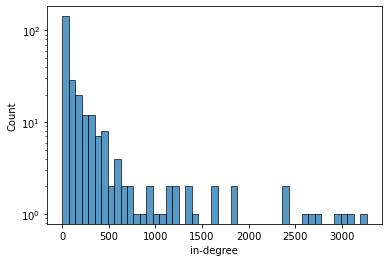

In [539]:
sns.histplot(in_counts, log_scale=[False, True]);
plt.xlabel('in-degree')

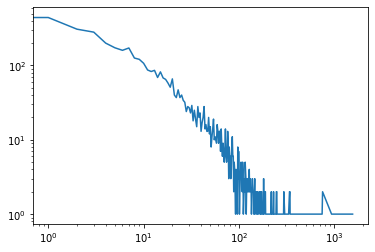

In [395]:
plt.loglog(in_counts.keys(), in_counts.values())

Text(0.5, 0, 'out-degree')

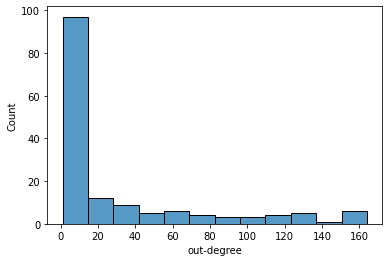

In [381]:
sns.histplot(out_counts);
plt.xlabel('out-degree')

The in-degree is clearly following a heavy-tailed distribution, hence a log scale is appropriate, at least in the y axis. Indeed, when plotted in a loglog scale, the in-degree distribution is close to a line, in particular between 10^1 and 10^2, and it could be thus approximated with a power law. The out-degree distribution, instead, does not seem to follow such a distribution, so a linear scale might be enough.

#### B1.3 Connectedness of the Wikipedia link network (4 points)

**Definition-1:** An undirected graph $G$ is said to be connected if, for every pair of vertices $(u, v)$, it contains a path that connects the two vertices.

**Definition-2:** A directed graph $G_{dir}$ is **weakly connected** (or simply connected) if the underlying undirected graph obtained by replacing all directed edges of the graph with undirected edges is a connected graph (cf. Definition-1). 

**Definition-3:** A directed graph $G_{dir}$ is **strongly connected** if, for every pair of vertices $(u, v)$, it contains a directed path from $u$ to $v$ and a directed path from $v$ to $u$.

Given these definitions, what can you say about the connectedness of the Wikipedia link network? Specifically, answer the following:
1. Is the Wikipedia link network weakly connected? If not, print the number of weakly connected components. Additionally, print the number of nodes and edges of the subgraph corresponding to the largest weakly connected component.
2. Is the Wikipedia link network strongly connected? If not, print the number of strongly connected components. Additionally, print the number of nodes and edges of the subgraph corresponding to the largest strongly connected component.

In [396]:
nx.is_weakly_connected(G)

False

In [399]:
weakly_cc = list(nx.weakly_connected_components(G))

In [400]:
print(f'The graph is not weakly connected. It has {len(weakly_cc)} weakly connected components.')

The graph is not weakly connected. It has 2 weakly connected components.


In [411]:
largest_wcc = G.subgraph(sorted(weakly_cc, key=len, reverse=True)[0])
nnodes = len(largest_wcc.nodes)
nedges = len(largest_wcc.edges)
print(f'The largest weakly connected component has {nnodes} nodes and {nedges} edges')

The largest weakly connected component has 4589 nodes and 119879 edges


In [412]:
nx.is_strongly_connected(G)

False

In [414]:
strongly_cc = list(nx.strongly_connected_components(G))

In [416]:
print(f'The graph is not strongly connected. It has {len(strongly_cc)} strongly connected components.')

The graph is not strongly connected. It has 519 strongly connected components.


In [417]:
largest_scc = G.subgraph(sorted(strongly_cc, key=len, reverse=True)[0])
nnodes = len(largest_scc.nodes)
nedges = len(largest_scc.edges)
print(f'The largest strongly connected component has {nnodes} nodes and {nedges} edges')

The largest strongly connected component has 4051 nodes and 111900 edges


### B2. The interplay between human navigation behavior and Wikipedia network structure (18 points)

#### B2.1 Loading and analyzing the game data (3 points)
1. Load `data/paths_df_task-B.tsv.gz` as a pandas dataframe.
2. Some games were successfully finished (*finished=True*) while others were unsuccessful (i.e., the player gave up before reaching the target article). However, not all unsuccessful games are infeasible; the player might simply not have been good enough at the game to reach the target from the source. **/Discuss:/** Clearly state the reasons why there may be games that are *truly infeasible*.   
3. List all unsuccessful games that are *truly infeasible* and remove them from the dataframe.

In [428]:
games = pd.read_csv('data/paths_df_task-B.tsv.gz', sep='\t')
games.source = games.source.apply(unquote)
games.target = games.target.apply(unquote)

In [429]:
games

,hashed_ip_address,source,target,finished,human_path_length,shortest_path_length,duration_in_sec
0,6a3701d319fc3754,14th_century,African_slave_trade,True,9,3,166
1,3824310e536af032,14th_century,African_slave_trade,True,5,3,88
2,415612e93584d30e,14th_century,African_slave_trade,True,8,3,138
3,64dd5cd342e3780c,14th_century,Greece,True,4,2,37
4,015245d773376aab,14th_century,John_F._Kennedy,True,7,3,175
...,...,...,...,...,...,...,...
76184,109ed71f571d86e9,Franz_Kafka,Cholera,False,8,3,180
76185,232f992e57d43e8d,Modern_history,Hollandic,False,1,3,6
76186,2e09a7224600a7cd,Computer_programming,The_Beatles,False,5,3,1900
76187,60af9e2138051b96,Jamaica,Alan_Turing,False,4,3,1903


2.

In some cases, there might not exist a shortest path between source and target, if the source and target article are not connected (i.e. there is no list of nodes starting from Source and ending with Target, s.t. for each node there exist an edge starting from it and ending in the following element in the sequence. In such cases, the game is  truly infeasible.

3.

In [430]:
infeasible_games = games[games.shortest_path_length == -1]

In [431]:
infeasible_games

,hashed_ip_address,source,target,finished,human_path_length,shortest_path_length,duration_in_sec
53533,4c03b8fb18fc9752,Oasis_(band),Final_Fantasy_(video_game),False,1,-1,13
56880,3af13b307343dec9,Adolf_Hitler,The_Frogs,False,6,-1,1874
63647,093e40d06992b8dc,Anne_Frank,Final_Fantasy_(video_game),False,21,-1,519
63648,093e42416992ba4d,Anne_Frank,Final_Fantasy_(video_game),False,21,-1,542
64511,17ef27577d43939d,Toy,Lego,False,1,-1,1807
66654,5e55877267bd6864,Hymenoptera,Portuguese_Communist_Party,False,8,-1,264
71566,3d9b105c56bcf38a,Private_Peaceful,Unix,False,1,-1,1804
75567,360d256e3fd2a746,Quantum_mechanics,Blue_Tit,False,15,-1,2464


In [499]:
games = games.drop(infeasible_games.index)

#### B2.2 Wikispeedia => Wikislowia? (9 points)
1. Compute and report the average and median path lengths for games that were successfully finished (*finished=True*). You should compute and report path length in two ways: (1) with respect to the number of clicks needed by *human players*, (2) with respect to the *minimum* number clicks an *optimal player* would need.   
   **/Discuss:/** What can you say about the navigability of the Wikipedia link network?   
   *Hint: Think about [Milgram's experiment](https://docs.google.com/presentation/d/1h6cIINJ9cNZ-Rtb7SskXrl9Xet5zPUoX2oJlNM0loHQ/edit#slide=id.g464f30ace1_0_261) and relate your findings with his findings!*
2. **/Discuss:/** Suppose you want to maliciously decrease Wikipedia's navigability. You are allowed to remove certain edges in the network. What criterion would you use to decide which edges should be removed? Additionally, discuss why these edges are critical for Wikipedia's navigability. Justify your answer with clear and substantive reasoning!   
   _Hint: Navigability of a network depends on the existence of short paths in the network._
3. **/Discuss:/** In continuation to B2.2.2, assume you are given a budget of $k<<n$ edges to be removed. Design the algorithm that you would employ, provide its pseudocode (as a list of steps), and justify your algorithm design choice.   
   *Note: You don't have to describe the steps for computing the criterion you identified in Step B.2.2. Instead, using the identified criterion as a blackbox, you have to provide the steps required to remove $k>1$ edges.*

In [500]:
# Human clicks
games[games.finished].human_path_length.agg(['mean', 'median'])

mean      6.757493
median    6.000000
Name: human_path_length, dtype: float64

In [501]:
# Optimal path
games[games.finished].shortest_path_length.agg(['mean', 'median'])

mean      2.8455
median    3.0000
Name: shortest_path_length, dtype: float64

The optimal paths are very short, below 3 links on average. This shows how the Wikipedia graph is indeed very connected and shortest paths are on average very short. While this is in general true also for random networks, more surprising is that also human paths are also very short, on average requiring between 6 and 7 clicks. This is remarkable as, in the human games, paths are discovered via greedy decentralized routing, without knowing the overall structure of the graph. The results are analogous to the ones obtained by Milgram in his famous experiment, and also the average length of 6.75 is very close to his average of 6.2!

2.

Navigability depends crucially on few nodes which have a high betweenness centrality, i.e. a lot of shortest paths pass through them. In general, this might correspond to articles corresponding to countries, disciplines or other big "categories", which can be crucial hub to move from the very specific detail of the Source article to the general domain, and then back to the detail of the Target article.

3.

A simple greedy algorithm would have a structure such as:

for i from 0 to k:   
    compute betweenness centrality of all nodes   
    compute node with highest betweenness centrality   
    remove the node from the graph with all its edges   
  
The choice of a greedy algorithm is justified by the fact that betweenness centrality is a very skewed metric and there are only few nodes with a very high betweenness centrality, which are crucial for connectivity.

#### B2.3 Relationship between network structure and game completion (6 points)
1. Enrich the dataframe with the eigenvector centrality and in-degree of the target article for each game path.
2. Using plots of appropriate type, plot the in-degree distribution of the target articles of game paths. What is the appropriate scale of the axes? Additionally, summarize the in-degree distribution of the target articles in a single number using a suitable metric. Justify your choice of the metric.
3. Using plots of appropriate type, analyze the differences in in-degree and eigenvector centrality of finished and unfinished games.   
   **/Discuss:/** What do you observe? Clearly discuss your observations!

In [502]:
eigen_centrality = nx.eigenvector_centrality(G)

In [503]:
centralities = [eigen_centrality[target] if target in eigen_centrality.keys() else None for target in games.target.values]
in_degrees = [G.in_degree(target) if target in G.nodes else None for target in games.target.values]

In [504]:
games['eigen_centr'] = centralities
games['in_degree'] = in_degrees

Text(0.5, 0, 'in-degree')

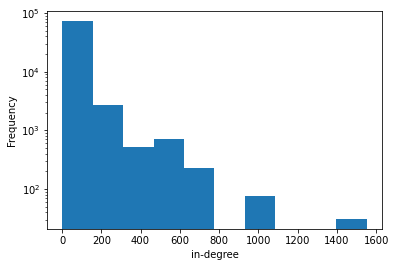

In [540]:
games.in_degree.plot.hist(log=True)
plt.xlabel('in-degree')

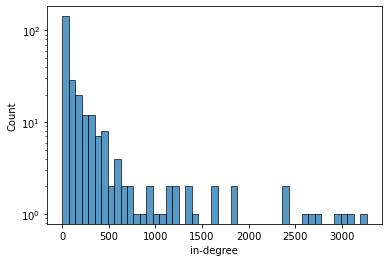

In [506]:
in_counts = Counter(games.in_degree)
in_counts = dict(sorted(in_counts.items(), key=itemgetter(0)))
sns.histplot(in_counts, log_scale=[False, True]);
plt.xlabel('in-degree');

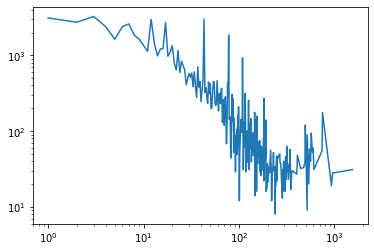

In [507]:
plt.loglog(in_counts.keys(), in_counts.values())

In [510]:
np.nanmedian(games.in_degree)

20.0

Again, the appropriate scale for visualizing the in-degree distribution, and the metric that is better summarizing the distribution with a single number is the median, since we are treating a heavy-tailed distribution.

3.

In [514]:
finished_games = games[games.finished]
unfinished_games = games[~games.finished]

In [536]:
in_counts_finished = Counter(finished_games.in_degree)
in_counts_finished = dict(sorted(in_counts_finished.items(), key=itemgetter(0)))

in_counts_unfinished = Counter(unfinished_games.in_degree)
in_counts_unfinished = dict(sorted(in_counts_unfinished.items(), key=itemgetter(0)))

Text(0.5, 1.0, 'Unfinished games')

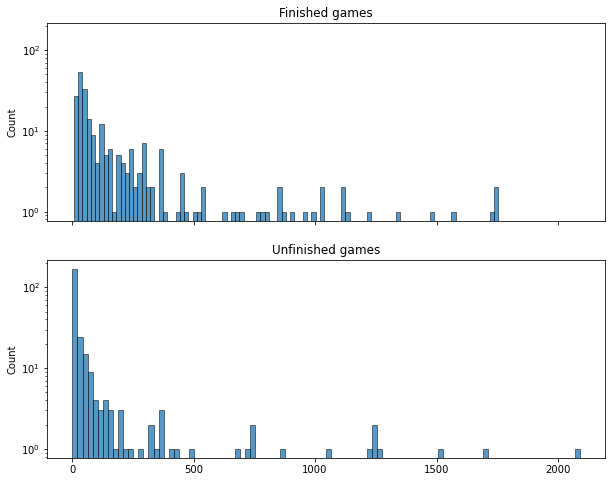

In [535]:
fig, ax = plt.subplots(2, sharex=True, sharey=True, figsize=(10, 8))

sns.histplot(in_counts_finished, bins=100, log_scale=[False, True], ax=ax[0]);
ax[0].set_title('Finished games')

sns.histplot(in_counts_unfinished, bins=100, log_scale=[False, True], ax=ax[1]);
ax[1].set_title('Unfinished games')

In [537]:
eigen_centr_finished = Counter(finished_games.eigen_centr)
eigen_centr_finished = dict(sorted(eigen_centr_finished.items(), key=itemgetter(0)))

eigen_centr_unfinished = Counter(unfinished_games.eigen_centr)
eigen_centr_unfinished = dict(sorted(eigen_centr_unfinished.items(), key=itemgetter(0)))

Text(0.5, 1.0, 'Unfinished games')

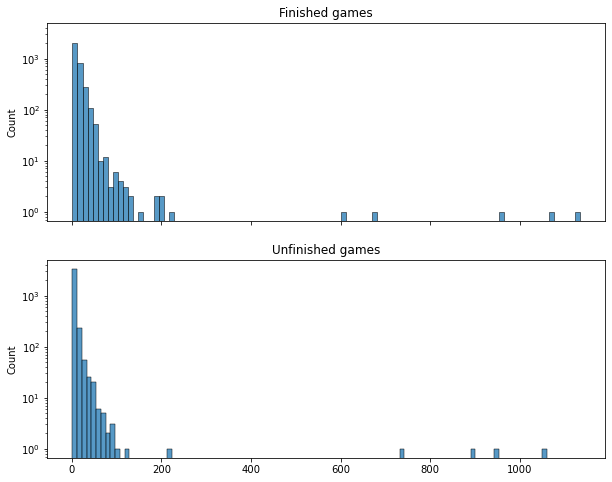

In [538]:
fig, ax = plt.subplots(2, sharex=True, sharey=True, figsize=(10, 8))

sns.histplot(eigen_centr_finished, bins=100, log_scale=[False, True], ax=ax[0]);
ax[0].set_title('Finished games')

sns.histplot(eigen_centr_unfinished, bins=100, log_scale=[False, True], ax=ax[1]);
ax[1].set_title('Unfinished games')

We remark that both the metric, eigenvalue centrality and in-degree for Target articles, are on general higher for finished games. This is reasonable, as Target articles that have a high in-degree or eigenvalue centrality are easier to reach, as they have more links coming in, hence the game is more likely to succeed.

# Task C. Putting on the causality hat (30 points)

### C1. Are articles with high in-degree easier to find? A naive analysis (6 points)

Recall that in each Wikispeedia game, a player is **randomly** assigned a source article and a target article. In task **C**, we are interested in measuring the effect of the target article's in-degree on the player's chances of successfully finishing the game.

1. Load `data/paths_df_task-C.tsv.gz` as a pandas dataframe.
2. Consider target articles with fewer than 20 incoming links to have a *low in-degree* and articles with at least 20 to have a *high in-degree*.
3. Calculate the fraction of games with a high-in-degree target that was finished, and the fraction of games with a low-in-degree target that was finished. Do you observe significant differences, and in what direction? (You may do a statistical test or provide confidence intervals.)
4. Repeat the same analysis for the game duration, for finished games only.
5. Quantify and discuss your findings from Steps C1.3 and C1.4.

1.

In [4]:
dataC = pd.read_csv('data/paths_df_task-C.tsv.gz', sep='\t')

In [5]:
dataC

,hashed_ip_address,source,target,finished,human_path_length,shortest_path_length,duration_in_sec,in_degree_target
0,6a3701d319fc3754,14th_century,African_slave_trade,True,9,3,166,7.0
1,3824310e536af032,14th_century,African_slave_trade,True,5,3,88,7.0
2,415612e93584d30e,14th_century,African_slave_trade,True,8,3,138,7.0
3,64dd5cd342e3780c,14th_century,Greece,True,4,2,37,246.0
4,015245d773376aab,14th_century,John_F._Kennedy,True,7,3,175,60.0
...,...,...,...,...,...,...,...,...
76176,109ed71f571d86e9,Franz_Kafka,Cholera,False,8,3,180,38.0
76177,232f992e57d43e8d,Modern_history,Hollandic,False,1,3,6,8.0
76178,2e09a7224600a7cd,Computer_programming,The_Beatles,False,5,3,1900,61.0
76179,60af9e2138051b96,Jamaica,Alan_Turing,False,4,3,1903,11.0


In [8]:
dataC['high_in_degree'] = dataC.in_degree_target >= 20

In [10]:
dataC.head()

,hashed_ip_address,source,target,finished,human_path_length,shortest_path_length,duration_in_sec,in_degree_target,high_in_degree
0,6a3701d319fc3754,14th_century,African_slave_trade,True,9,3,166,7.0,False
1,3824310e536af032,14th_century,African_slave_trade,True,5,3,88,7.0,False
2,415612e93584d30e,14th_century,African_slave_trade,True,8,3,138,7.0,False
3,64dd5cd342e3780c,14th_century,Greece,True,4,2,37,246.0,True
4,015245d773376aab,14th_century,John_F._Kennedy,True,7,3,175,60.0,True


In [28]:
# High in-degree games
dataC_hd = dataC[dataC.high_in_degree]

In [29]:
# Fraction of finished games
dataC_hd.finished.mean()

0.777918813942271

In [30]:
# Low in-degree games
dataC_ld = dataC[~dataC.high_in_degree]

In [31]:
# Fraction of finished games
dataC_ld.finished.mean()

0.5618646371296548

The two samples come from two Bernoulli distributions, such that the probability of completing a game is given by some constant $\pi$, which can experimentally be estimated by computing the empirical mean (ratio) of finished games. Hence, we are interested in knowing if the two distributions (for high in-degree and low in-degree games) have the same $\pi$, i.e. the same mean. For this scope, we can use an independent t-test to compare the means of the two samples. This in general is possible thanks to the central limit theorem and the fact that we are dealining with a large number of games: the distribution of the mean will be approximately normal.

In [34]:
stats.ttest_ind(dataC_hd.finished, dataC_ld.finished)

Ttest_indResult(statistic=65.30438592344109, pvalue=0.0)

The test shows that the difference is extremely significant. The p-value is almost 0, thus in the hypothesis of the two samples coming from the same Bernoulli distribution, the probability of obtaining a difference at least as extreme as the one observed, is almost 0.

4.

In [35]:
dataC_hd_finished = dataC_hd[dataC_hd.finished]

In [37]:
dataC_hd_finished.duration_in_sec.mean()

130.42851548477628

In [38]:
dataC_ld_finished = dataC_ld[dataC_ld.finished]

In [40]:
dataC_ld_finished.duration_in_sec.mean()

199.57196071791398

In [41]:
stats.ttest_ind(dataC_hd_finished.duration_in_sec, dataC_ld_finished.duration_in_sec)

Ttest_indResult(statistic=-21.38300527091685, pvalue=5.3178885355993734e-101)

In this case, the distribution of game durations will likely be normal, and the argument for using the t-test is the same as before. Again, the probability of obtaining a differene at least as extreme as the obtained one is almost 0, hence the difference is extremely significant.

5.

The results above show a significant correlation between the ratio of finished game and the in-degree, and a very significant correlation between the duration of finished games and the in-degree, both findings suggesting that Target articles with a high in-degree are easier to find, and findable in a shorter time, which corresponds to common intuition.

### C2. Modeling the study setup with a causal diagram (9 points)

**C2.1** We are interested in the effect of target in-degree (**deg(T)**) on the binary outcome **(O)** that captures whether the game was successfully finished or not. In the previously conducted naive analysis, we did not take into account the shortest path length **(L)**, which is the minimum number of clicks necessary in order to reach the target article from the source article **(S)**. Target and source articles are randomly assigned, independently from each other. The assigned source article S and deg(T) affect the shortest path length L. The source article affects the outcome through the shortest path length, and also directly, as some sources might be more central in the network.   
Choose a causal diagram **(A, B, C, D, E, or F)** that corresponds to the described relationships between the following 4 variables. Additionally, justify your choice and explain your reasoning. **(4 points)**
- **deg(T):** target in-degree,
- **L:** shortest path length between source and target,
- **S:** name of source article,
- **O:** outcome, i.e., the binary indicator that says whether the game was successfully finished.

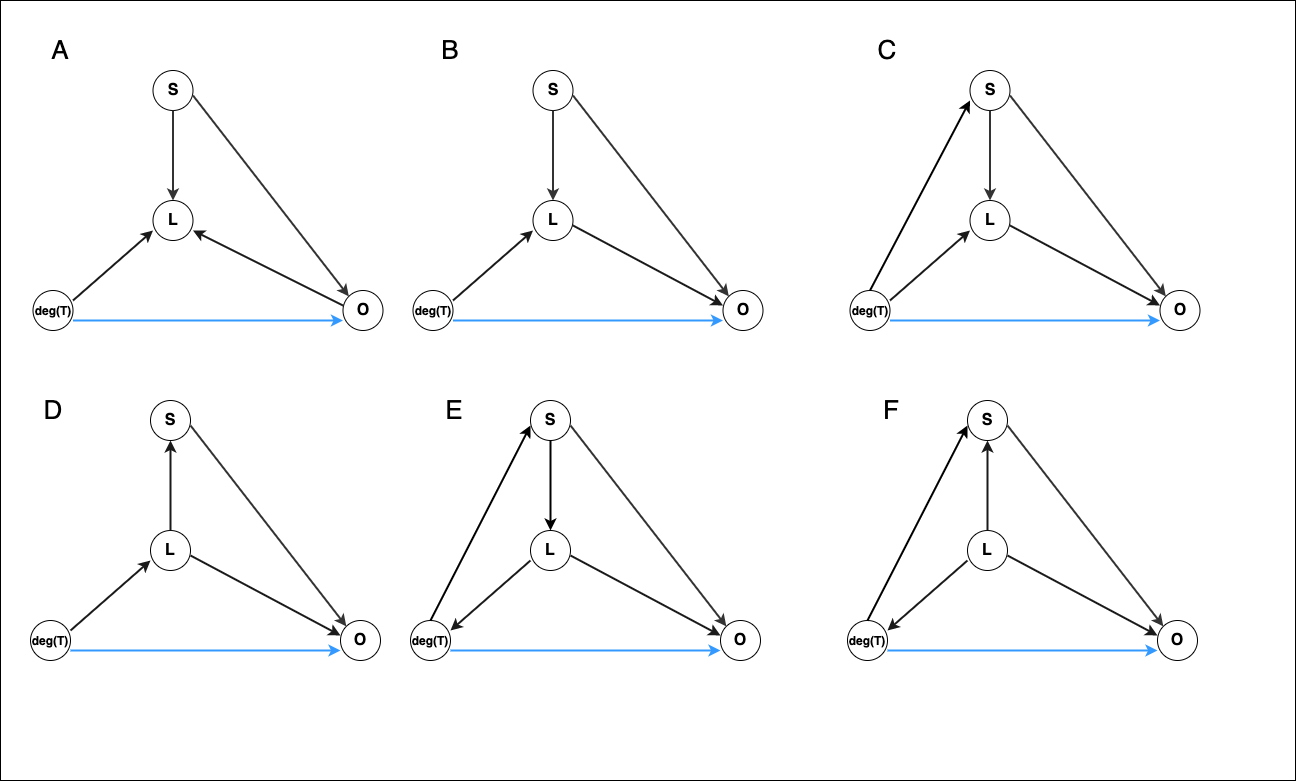

In [16]:
Image(filename="img/diagram.png") 

The correct diagram is B. In general, an arrow represent a causal relationship from its start to its end. C, E and F cannot be correct S and T are randomly extracted, and there cannot be a causal relationship between S and deg(T). A must be discarded since the outcome cannot influence any of the path properties, such as L, but only be influenced. Finally, D must be discarded since L is causally dependent on S and not viceversa. B shows instead all the described relationships: S and deg(T) affect L, which affect O toghether with S. What we want to establish in our observational study, is the existence of the blue arrow between deg(T) and O.

**C2.2** **/Discuss:/** What is potentially misleading about the naive analysis done in task **C1**? In what conceivable ways could the conclusions about the impact of target in-degree **deg(T)** on the outcome **O** be wrong?
Could the findings go in the opposite direction of a true direct causal effect? Justify your answer. **(5 points)**

The analysis in C1 is not taking into account the shortest path length L, which can be a counfounder in the above results. In general, the difficulty of a game might not be directly dependent on the in-degree of T, as the naive analysis seemed to suggest, but rather on the shortest path length and only be correlated with deg(T) but now casually dependent. If this is the case than  deg(T) is only a proxy of L but ultimately does not tell us anything about the difficulty of the game, and two games with same deg(T) but different L will have very different difficulties. For example, one could have a Target with very high deg(T), but links coming only from articles with in-degree 0 (which do not include S), in which case a shortest path woudn't even exist, hence the game would not be finishable!

### C3. A more controlled analysis: matching on source article and shortest path length (15 points)

Let's now understand how the estimated effect of the target in-degree would differ if we controlled for both the source article and the shortest path length between source and target. Construct a set of matched pairs of games. In a matched pair, the two games differ in target in-degree (one has a high in-degree, and the other has a low in-degree), but the source article and the shortest path length are exactly the same. Note that your output must be a 1-to-1 matching.

1. Perform exact matching on source article and shortest path length. This means that two candidate games can be matched only if the source article and the shortest path length are exactly the same. Additionally, report the number of matched pairs of games. **(7 points)**   
   **Important heads-up**: *Depending on the configuration of your computer, computing the exact matching could take up to 3 minutes of compute time.*
2. Among the matched pairs of games, calculate the fraction of games with a high-in-degree target that was successfully finished, and the fraction of games with a low-in-degree target that was successfully finished. Do you observe significant differences, and in what direction? (You may do a statistical test or provide confidence intervals.) **(3 points)**
3. **/Discuss:/** What do you observe? Are the conclusions different from the conclusions reached in C1? If yes, speculate as to why that is the case. How is the estimation in task C1 different from the estimation in task C3? **(4 points)**
4. **/Discuss:/** Based on your findings, how should Wikipedia be modified in order to increase the fraction of finished Wikispeedia games? **(1 points)**

*Hint: How you construct the set of matched pairs is up to you. One way can be to build an unweighted bipartite graph where games with targets with a high in-degree are on one side (the "treated class"), and games with targets with a low in-degree are on the other side (the "control class"). The edge between two matching candidate games is created only if there is an exact match on the source article and the shortest path length. Based on this bipartite graph, you can then find the **optimal** matching. However, note that this is neither the required nor the only way.*

1.

In [103]:
def match(data):
    '''
    Perform 1-1 matching on an input DataFrame (data) of articles with the same source and same shortest_path_length
    '''
    groups = data.groupby('high_in_degree')
    
    # Count group elements
    counts = groups.source.count()
    
    # If one of the two groups is empty, return None
    if(len(counts) == 1):
        return None
    
    # Get the lowest number of elements
    min_count = min(counts)
        
    # Take min_count elements from each group
    return groups.head(min_count)

In [104]:
dataC_matched = dataC.groupby(['source', 'shortest_path_length']).apply(match)

In [105]:
dataC_matched.reset_index(drop=True, inplace=True)

In [117]:
dataC_matched.head(10)

,hashed_ip_address,source,target,finished,human_path_length,shortest_path_length,duration_in_sec,in_degree_target,high_in_degree
0,0d57c8c57d75e2f5,10th_century,Country,True,3,2,15,82.0,True
1,32652d6d1c5d9351,10th_century,Banknote,True,5,2,48,18.0,False
2,141f87754abb36d2,10th_century,Marco_Polo,True,5,3,46,21.0,True
3,40111bc7370e59f5,10th_century,Harlem_Globetrotters,True,5,3,92,3.0,False
4,02c024aa1458f9c8,10th_century,Harlem_Globetrotters,True,4,3,58,3.0,False
5,6a256705580ff6fe,10th_century,Mark_Twain,False,4,3,2046,33.0,True
6,5ad0c88c281e235b,11th_century,Education_in_the_United_States,True,5,3,58,3.0,False
7,1ce9d4ef25286aa2,11th_century,Ho_Chi_Minh,True,5,3,89,8.0,False
8,36fb42e7086e8ff5,11th_century,Dimetrodon,True,9,3,211,5.0,False
9,0fe068f1255bb0ea,11th_century,Plum,True,8,3,77,13.0,False


In [112]:
print(f'After 1-1 matching, we remain with {len(dataC_matched)} games')

After 1-1 matching, we remain with 25420 games


2.

In [118]:
# High in-degree games
dataC_matched_hd = dataC_matched[dataC_matched.high_in_degree]
# Fraction of finished games
dataC_matched_hd.finished.mean()

0.8693154996066089

In [119]:
# Low in-degree games
dataC_matched_ld = dataC_matched[~dataC_matched.high_in_degree]
# Fraction of finished games
dataC_matched_ld.finished.mean()

0.7219512195121951

In [120]:
stats.ttest_ind(dataC_matched_hd.finished, dataC_matched_ld.finished)

Ttest_indResult(statistic=29.630946471004435, pvalue=1.005074906998764e-189)

Again, the probability of obtaining a difference at least as extreme as the obtained one is almost 0, and the difference is thus extremely significant.

3.

After matching, it seems that high Target in-degree has still a significant role, and the results of C1 are confirmed. In fact, the the ratio of finished games is significantly different for games with high and low deg(T), even after matching for games with the same source S and shortest path length L, which is balancing the impact of the covariates S and L between the two matched groups (high deg(T) and low(T)), hence removing their overall impact. The difference left, less than the one observed in C1 but still extremely significant, is thus directly dependent on deg(T), which we can conclude has a causal relationship with the outcome O.

4.

To improve the results of Wikispeedia games, the easy modification would be to increase the overall in-degree of articles, by adding more edges to the Wikipedia graph, corresponding to adding more wikilinks on articles.